#Pytorch experiments


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from dataloader import DataLoader
from os.path import abspath
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
print(abspath('./'))
loader = DataLoader(10)
loader.parse_person_corpus(abspath('../Persons-1000/collection'))
loader.parse_rdf_corpus(abspath('../../corpus_for_pakhomov_2'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ep = EntriesProcessor(20,40)
# voc_size = 10
ep.process(loader.entries)
voc_size = ep.symbols_counter
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

C:\Users\Sdernal\Desktop\Jackals\TextNormalization\WithPytorch


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Абдулла Гюль.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Адам Осмаев.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Азим Исабеков.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Глухов.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Ломая.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Медведько.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Анатолий Бибилов.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Андрей Аршавин.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Владимир Сергеевич Высоцкий.xml


'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Евгений Чичваркин.xml


In [2]:
train_losses_all, test_losses_all = [], []

In [12]:
train_losses, test_losses = trainer.train(10, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1


	Train Loss: 0.183823 	 Time: 0s

	Train Loss: 0.236037 	 Time: 0s

	Train Loss: 0.224887 	 Time: 0s

	Train Loss: 0.210451 	 Time: 1s

	Train Loss: 0.209399 	 Time: 1s

	Train Loss: 0.222516 	 Time: 1s

	Train Loss: 0.207102 	 Time: 2s

	Train Loss: 0.202910 	 Time: 2s

	Train Loss: 0.200004 	 Time: 2s

	Train Loss: 0.197837 	 Time: 2s

	Train Loss: 0.196579 	 Time: 2s

	Train Loss: 0.191918 	 Time: 3s

	Train Loss: 0.195556 	 Time: 3s

	Train Loss: 0.188652 	 Time: 3s

	Train Loss: 0.183881 	 Time: 4s

	Train Loss: 0.198428 	 Time: 4s

	Train Loss: 0.206280 	 Time: 5s

	Train Loss: 0.202526 	 Time: 5s

	Train Loss: 0.201962 	 Time: 5s

	Train Loss: 0.197244 	 Time: 6s

	Train Loss: 0.203053 	 Time: 6s

	Train Loss: 0.199927 	 Time: 7s

	Train Loss: 0.200067 	 Time: 7s

	Train Loss: 0.201027 	 Time: 7s

	Train Loss: 0.205142 	 Time: 8s

	Train Loss: 0.207165 	 Time: 8s

	Train Loss: 0.207475 	 Time: 8s

	Train Loss: 0.206249 	 Time: 9s

	Train Loss: 0.205053 	 Time: 9s

	Train Loss: 0.202491 	 Time: 10s

	Train Loss: 0.200334 	 Time: 10s

	Train Loss: 0.201919 	 Time: 10s

	Train Loss: 0.211430 	 Time: 11s

	Train Loss: 0.214394 	 Time: 11s

	Train Loss: 0.212843 	 Time: 12s

	Train Loss: 0.213418 	 Time: 12s

	Train Loss: 0.213765 	 Time: 12s

	Train Loss: 0.211845 	 Time: 13s

	Train Loss: 0.212119 	 Time: 13s

	Train Loss: 0.211607 	 Time: 13s

	Train Loss: 0.213727 	 Time: 14s

	Train Loss: 0.213922 	 Time: 14s

	Train Loss: 0.215729 	 Time: 15s

	Train Loss: 0.215294 	 Time: 15s

	Train Loss: 0.216397 	 Time: 15s

	Train Loss: 0.216548 	 Time: 16s

	Train Loss: 0.215659 	 Time: 16s

	Train Loss: 0.218976 	 Time: 17s

	Train Loss: 0.220322 	 Time: 17s

	Train Loss: 0.222145 	 Time: 17s

	Train Loss: 0.223581 	 Time: 18s

	Train Loss: 0.223800 	 Time: 18s

	Train Loss: 0.224463 	 Time: 18s

	Train Loss: 0.223475 	 Time: 19s

	Train Loss: 0.225358 	 Time: 19s

	Train Loss: 0.224225 	 Time: 20s

	Train Loss: 0.224039 	 Time: 20s

	Train Loss: 0.226017 	 Time: 20s

	Train Loss: 0.227814 	 Time: 21s

	Train Loss: 0.227134 	 Time: 21s

	Train Loss: 0.228240 	 Time: 22s

	Train Loss: 0.228325 	 Time: 22s

	Train Loss: 0.227204 	 Time: 22s

	Train Loss: 0.227858 	 Time: 23s

	Train Loss: 0.228061 	 Time: 23s

	Train Loss: 0.228128 	 Time: 24s

	Train Loss: 0.227752 	 Time: 24s

	Train Loss: 0.228407 	 Time: 24s

	Train Loss: 0.229748 	 Time: 25s


	Test Loss: 0.266671 	 Time: 0s
	 Input: раины.

юлия тимошенко не будет  	 Result: юлия тимошенко 	 From train: 1
	 Input: ии палаты владимир федоткин , его зам 	 Result: владимир федоткин 	 From train: 1
	 Input: ированный источник", сообщал 	 Result: источник 	 From train: 1


	 Input:  руслан и сулим получили  	 Result: сулим 	 From train: 1
	 Input: ссертации ливанов начал раб 	 Result: ливановов 	 From train: 0
Epoch 2


	Train Loss: 0.333358 	 Time: 0s

	Train Loss: 0.339597 	 Time: 0s

	Train Loss: 0.295811 	 Time: 1s

	Train Loss: 0.306590 	 Time: 1s

	Train Loss: 0.311196 	 Time: 1s

	Train Loss: 0.287017 	 Time: 2s

	Train Loss: 0.299340 	 Time: 2s

	Train Loss: 0.294748 	 Time: 3s

	Train Loss: 0.295469 	 Time: 3s

	Train Loss: 0.280826 	 Time: 3s

	Train Loss: 0.271929 	 Time: 4s

	Train Loss: 0.262775 	 Time: 4s

	Train Loss: 0.261744 	 Time: 5s

	Train Loss: 0.267963 	 Time: 5s

	Train Loss: 0.266659 	 Time: 5s

	Train Loss: 0.267356 	 Time: 6s

	Train Loss: 0.265054 	 Time: 6s

	Train Loss: 0.259097 	 Time: 6s

	Train Loss: 0.253292 	 Time: 7s

	Train Loss: 0.254673 	 Time: 7s

	Train Loss: 0.253585 	 Time: 8s

	Train Loss: 0.252352 	 Time: 8s

	Train Loss: 0.256542 	 Time: 8s

	Train Loss: 0.258033 	 Time: 9s

	Train Loss: 0.255059 	 Time: 9s

	Train Loss: 0.254187 	 Time: 10s

	Train Loss: 0.252424 	 Time: 10s

	Train Loss: 0.253304 	 Time: 10s

	Train Loss: 0.249878 	 Time: 11s

	Train Loss: 0.249898 	 Time: 11s

	Train Loss: 0.251633 	 Time: 12s

	Train Loss: 0.255026 	 Time: 12s

	Train Loss: 0.254553 	 Time: 12s

	Train Loss: 0.252058 	 Time: 13s

	Train Loss: 0.249898 	 Time: 13s

	Train Loss: 0.249230 	 Time: 14s

	Train Loss: 0.247217 	 Time: 14s

	Train Loss: 0.247159 	 Time: 14s

	Train Loss: 0.248064 	 Time: 15s

	Train Loss: 0.246828 	 Time: 15s

	Train Loss: 0.246735 	 Time: 15s

	Train Loss: 0.246527 	 Time: 16s

	Train Loss: 0.244185 	 Time: 16s

	Train Loss: 0.244142 	 Time: 16s

	Train Loss: 0.245763 	 Time: 17s

	Train Loss: 0.245676 	 Time: 17s

	Train Loss: 0.245471 	 Time: 18s

	Train Loss: 0.244954 	 Time: 18s

	Train Loss: 0.245389 	 Time: 18s

	Train Loss: 0.245804 	 Time: 19s

	Train Loss: 0.246146 	 Time: 19s

	Train Loss: 0.246399 	 Time: 20s

	Train Loss: 0.244472 	 Time: 20s

	Train Loss: 0.245640 	 Time: 20s

	Train Loss: 0.245077 	 Time: 21s

	Train Loss: 0.246427 	 Time: 21s

	Train Loss: 0.248220 	 Time: 22s

	Train Loss: 0.247856 	 Time: 22s

	Train Loss: 0.246194 	 Time: 22s

	Train Loss: 0.245263 	 Time: 23s

	Train Loss: 0.245434 	 Time: 23s

	Train Loss: 0.244982 	 Time: 23s

	Train Loss: 0.246769 	 Time: 24s

	Train Loss: 0.247222 	 Time: 24s


	Test Loss: 0.233426 	 Time: 0s
	 Input: ретариата касьянова в правите 	 Result: касьянов 	 From train: 1
	 Input: ца, дево, путина прогони", 	 Result: путин 	 From train: 1
	 Input: авляемого куловым правитель 	 Result: кулов 	 From train: 1


	 Input: гозин.

в.сурков пришел в  	 Result: в сурков 	 From train: 1
	 Input: а также и шона салливана, имевшего 	 Result: шон салливан 	 From train: 1
Epoch 3


	Train Loss: 0.291605 	 Time: 0s

	Train Loss: 0.276493 	 Time: 0s

	Train Loss: 0.230103 	 Time: 0s

	Train Loss: 0.274154 	 Time: 1s

	Train Loss: 0.254613 	 Time: 1s

	Train Loss: 0.246882 	 Time: 1s

	Train Loss: 0.251710 	 Time: 2s

	Train Loss: 0.266451 	 Time: 2s

	Train Loss: 0.270727 	 Time: 3s

	Train Loss: 0.258818 	 Time: 3s

	Train Loss: 0.264617 	 Time: 3s

	Train Loss: 0.264193 	 Time: 4s

	Train Loss: 0.263218 	 Time: 4s

	Train Loss: 0.261620 	 Time: 5s

	Train Loss: 0.260358 	 Time: 5s

	Train Loss: 0.259415 	 Time: 5s

	Train Loss: 0.260838 	 Time: 6s

	Train Loss: 0.261758 	 Time: 6s

	Train Loss: 0.257158 	 Time: 6s

	Train Loss: 0.260986 	 Time: 7s

	Train Loss: 0.256801 	 Time: 7s

	Train Loss: 0.251461 	 Time: 7s

	Train Loss: 0.247853 	 Time: 8s

	Train Loss: 0.247121 	 Time: 8s

	Train Loss: 0.247622 	 Time: 9s

	Train Loss: 0.243867 	 Time: 9s

	Train Loss: 0.240804 	 Time: 9s

	Train Loss: 0.245695 	 Time: 10s

	Train Loss: 0.242200 	 Time: 10s

	Train Loss: 0.245181 	 Time: 11s

	Train Loss: 0.245266 	 Time: 11s

	Train Loss: 0.241964 	 Time: 11s

	Train Loss: 0.242302 	 Time: 12s

	Train Loss: 0.244025 	 Time: 12s

	Train Loss: 0.240619 	 Time: 13s

	Train Loss: 0.240418 	 Time: 13s

	Train Loss: 0.239291 	 Time: 13s

	Train Loss: 0.241695 	 Time: 14s

	Train Loss: 0.241294 	 Time: 14s

	Train Loss: 0.239653 	 Time: 14s

	Train Loss: 0.240991 	 Time: 15s

	Train Loss: 0.241571 	 Time: 15s

	Train Loss: 0.242046 	 Time: 16s

	Train Loss: 0.245112 	 Time: 16s

	Train Loss: 0.245277 	 Time: 16s

	Train Loss: 0.245170 	 Time: 17s

	Train Loss: 0.243058 	 Time: 17s

	Train Loss: 0.242203 	 Time: 17s

	Train Loss: 0.242924 	 Time: 18s

	Train Loss: 0.243613 	 Time: 18s

	Train Loss: 0.243897 	 Time: 19s

	Train Loss: 0.245738 	 Time: 19s

	Train Loss: 0.248348 	 Time: 19s

	Train Loss: 0.250829 	 Time: 20s

	Train Loss: 0.251591 	 Time: 20s

	Train Loss: 0.249650 	 Time: 21s

	Train Loss: 0.250740 	 Time: 21s

	Train Loss: 0.251841 	 Time: 21s

	Train Loss: 0.250739 	 Time: 22s

	Train Loss: 0.252984 	 Time: 22s

	Train Loss: 0.252851 	 Time: 23s

	Train Loss: 0.251774 	 Time: 23s

	Train Loss: 0.252826 	 Time: 23s

	Train Loss: 0.253067 	 Time: 24s

	Train Loss: 0.251307 	 Time: 24s

	Train Loss: 0.250555 	 Time: 24s


	Test Loss: 0.228873 	 Time: 0s
	 Input: цназа гру эдуардом ульманом , предста 	 Result: эдуард ульман 	 From train: 1
	 Input:  его брат владимир басманов - национа 	 Result: владимир басманов 	 From train: 1
	 Input: арднадзе, гиоргадзе был уволе 	 Result: гиоргадзе 	 From train: 1


	 Input: озглавлял борис алешин. 1 декабр 	 Result: борис алешин 	 From train: 0
	 Input: келя (сам френкель утвержден 	 Result: френкель 	 From train: 1
Epoch 4


	Train Loss: 0.329758 	 Time: 0s

	Train Loss: 0.312008 	 Time: 0s

	Train Loss: 0.291287 	 Time: 1s

	Train Loss: 0.249029 	 Time: 1s

	Train Loss: 0.238318 	 Time: 1s

	Train Loss: 0.223579 	 Time: 2s

	Train Loss: 0.226661 	 Time: 2s

	Train Loss: 0.226216 	 Time: 2s

	Train Loss: 0.235228 	 Time: 3s

	Train Loss: 0.230130 	 Time: 3s

	Train Loss: 0.236487 	 Time: 4s

	Train Loss: 0.251778 	 Time: 4s

	Train Loss: 0.256358 	 Time: 4s

	Train Loss: 0.250128 	 Time: 5s

	Train Loss: 0.252924 	 Time: 5s

	Train Loss: 0.259832 	 Time: 6s

	Train Loss: 0.262519 	 Time: 6s

	Train Loss: 0.265059 	 Time: 6s

	Train Loss: 0.266053 	 Time: 7s

	Train Loss: 0.264039 	 Time: 7s

	Train Loss: 0.262995 	 Time: 7s

	Train Loss: 0.266246 	 Time: 8s

	Train Loss: 0.267596 	 Time: 8s

	Train Loss: 0.271340 	 Time: 9s

	Train Loss: 0.269856 	 Time: 9s

	Train Loss: 0.266004 	 Time: 9s

	Train Loss: 0.261836 	 Time: 10s

	Train Loss: 0.260701 	 Time: 10s

	Train Loss: 0.262573 	 Time: 10s

	Train Loss: 0.261653 	 Time: 11s

	Train Loss: 0.260202 	 Time: 11s

	Train Loss: 0.258842 	 Time: 12s

	Train Loss: 0.260885 	 Time: 12s

	Train Loss: 0.258665 	 Time: 12s

	Train Loss: 0.257250 	 Time: 13s

	Train Loss: 0.254426 	 Time: 13s

	Train Loss: 0.255642 	 Time: 14s

	Train Loss: 0.257946 	 Time: 14s

	Train Loss: 0.259715 	 Time: 14s

	Train Loss: 0.257487 	 Time: 15s

	Train Loss: 0.255619 	 Time: 15s

	Train Loss: 0.254545 	 Time: 16s

	Train Loss: 0.255759 	 Time: 16s

	Train Loss: 0.253899 	 Time: 16s

	Train Loss: 0.253050 	 Time: 17s

	Train Loss: 0.252464 	 Time: 17s

	Train Loss: 0.251350 	 Time: 17s

	Train Loss: 0.250697 	 Time: 18s

	Train Loss: 0.249995 	 Time: 18s

	Train Loss: 0.248924 	 Time: 19s

	Train Loss: 0.248772 	 Time: 19s

	Train Loss: 0.249144 	 Time: 19s

	Train Loss: 0.249375 	 Time: 20s

	Train Loss: 0.249253 	 Time: 20s

	Train Loss: 0.247649 	 Time: 20s

	Train Loss: 0.248855 	 Time: 21s

	Train Loss: 0.247014 	 Time: 21s

	Train Loss: 0.248572 	 Time: 22s

	Train Loss: 0.248090 	 Time: 22s

	Train Loss: 0.249310 	 Time: 22s

	Train Loss: 0.249376 	 Time: 23s

	Train Loss: 0.247689 	 Time: 23s

	Train Loss: 0.246113 	 Time: 23s

	Train Loss: 0.244668 	 Time: 24s

	Train Loss: 0.243618 	 Time: 24s


	Test Loss: 0.240173 	 Time: 0s
	 Input: бульбова. александр михайлов, официаль 	 Result: александр михайлов 	 From train: 1
	 Input: лена гкчп бориса пуго, который  	 Result: борис пуго 	 From train: 1
	 Input: это место леонида невзлина. в марте  	 Result: леонид невзлин 	 From train: 1


	 Input: ент банка виестурс нейманис (viesturs 	 Result: виестурс нейманис 	 From train: 1
	 Input: верждение лукашенко" роли сво 	 Result: лукашенко 	 From train: 1
Epoch 5


	Train Loss: 0.224010 	 Time: 0s

	Train Loss: 0.240874 	 Time: 0s

	Train Loss: 0.210873 	 Time: 1s

	Train Loss: 0.195294 	 Time: 1s

	Train Loss: 0.185264 	 Time: 1s

	Train Loss: 0.194734 	 Time: 2s

	Train Loss: 0.203512 	 Time: 2s

	Train Loss: 0.211355 	 Time: 3s

	Train Loss: 0.218760 	 Time: 3s

	Train Loss: 0.225041 	 Time: 3s

	Train Loss: 0.229774 	 Time: 4s

	Train Loss: 0.233263 	 Time: 4s

	Train Loss: 0.230761 	 Time: 4s

	Train Loss: 0.233112 	 Time: 5s

	Train Loss: 0.240361 	 Time: 5s

	Train Loss: 0.234005 	 Time: 6s

	Train Loss: 0.228045 	 Time: 6s

	Train Loss: 0.223376 	 Time: 6s

	Train Loss: 0.224559 	 Time: 7s

	Train Loss: 0.226052 	 Time: 7s

	Train Loss: 0.227536 	 Time: 7s

	Train Loss: 0.231413 	 Time: 8s

	Train Loss: 0.227519 	 Time: 8s

	Train Loss: 0.224166 	 Time: 9s

	Train Loss: 0.227268 	 Time: 9s

	Train Loss: 0.227710 	 Time: 9s

	Train Loss: 0.230179 	 Time: 10s

	Train Loss: 0.228707 	 Time: 10s

	Train Loss: 0.228928 	 Time: 11s

	Train Loss: 0.227690 	 Time: 11s

	Train Loss: 0.226086 	 Time: 11s

	Train Loss: 0.223629 	 Time: 12s

	Train Loss: 0.221358 	 Time: 12s

	Train Loss: 0.220348 	 Time: 13s

	Train Loss: 0.227694 	 Time: 13s

	Train Loss: 0.229202 	 Time: 13s

	Train Loss: 0.232880 	 Time: 14s

	Train Loss: 0.232117 	 Time: 14s

	Train Loss: 0.232517 	 Time: 14s

	Train Loss: 0.233186 	 Time: 15s

	Train Loss: 0.235628 	 Time: 15s

	Train Loss: 0.235111 	 Time: 16s

	Train Loss: 0.236574 	 Time: 16s

	Train Loss: 0.235766 	 Time: 16s

	Train Loss: 0.233959 	 Time: 17s

	Train Loss: 0.232893 	 Time: 17s

	Train Loss: 0.232193 	 Time: 17s

	Train Loss: 0.232478 	 Time: 18s

	Train Loss: 0.235317 	 Time: 18s

	Train Loss: 0.234207 	 Time: 19s

	Train Loss: 0.234536 	 Time: 19s

	Train Loss: 0.234232 	 Time: 19s

	Train Loss: 0.235037 	 Time: 20s

	Train Loss: 0.235552 	 Time: 20s

	Train Loss: 0.233907 	 Time: 20s

	Train Loss: 0.232314 	 Time: 21s

	Train Loss: 0.232117 	 Time: 21s

	Train Loss: 0.231230 	 Time: 22s

	Train Loss: 0.231115 	 Time: 22s

	Train Loss: 0.231298 	 Time: 23s

	Train Loss: 0.231474 	 Time: 23s

	Train Loss: 0.231770 	 Time: 23s

	Train Loss: 0.231083 	 Time: 24s

	Train Loss: 0.230650 	 Time: 24s

	Train Loss: 0.230047 	 Time: 24s

	Train Loss: 0.229648 	 Time: 24s

	Train Loss: 0.230888 	 Time: 25s


	Test Loss: 0.247592 	 Time: 0s
	 Input: е украины дмитрий фирташ и иван фу 	 Result: дмитрий фирташ 	 From train: 1
	 Input: й области виктор гречман освобожде 	 Result: виктор гречман 	 From train: 1
	 Input: емократом джоном эдвардсом (john edw 	 Result: джон эдвардс 	 From train: 1


	 Input:  отправил лужкова в отставк 	 Result: лужков 	 From train: 1
	 Input: ительства саддама хусейна в ираке.  	 Result: саддам хусейн 	 From train: 1
Epoch 6


	Train Loss: 0.206278 	 Time: 0s

	Train Loss: 0.216640 	 Time: 0s

	Train Loss: 0.215816 	 Time: 1s

	Train Loss: 0.239824 	 Time: 1s

	Train Loss: 0.223334 	 Time: 1s

	Train Loss: 0.221456 	 Time: 2s

	Train Loss: 0.223016 	 Time: 2s

	Train Loss: 0.214608 	 Time: 3s

	Train Loss: 0.212143 	 Time: 3s

	Train Loss: 0.217268 	 Time: 3s

	Train Loss: 0.219236 	 Time: 4s

	Train Loss: 0.212725 	 Time: 4s

	Train Loss: 0.214742 	 Time: 4s

	Train Loss: 0.221095 	 Time: 5s

	Train Loss: 0.215778 	 Time: 5s

	Train Loss: 0.217742 	 Time: 5s

	Train Loss: 0.213546 	 Time: 6s

	Train Loss: 0.220696 	 Time: 6s

	Train Loss: 0.226581 	 Time: 7s

	Train Loss: 0.222344 	 Time: 7s

	Train Loss: 0.221104 	 Time: 7s

	Train Loss: 0.217261 	 Time: 8s

	Train Loss: 0.214443 	 Time: 8s

	Train Loss: 0.211675 	 Time: 9s

	Train Loss: 0.209650 	 Time: 9s

	Train Loss: 0.206501 	 Time: 9s

	Train Loss: 0.210942 	 Time: 10s

	Train Loss: 0.210029 	 Time: 10s

	Train Loss: 0.208731 	 Time: 11s

	Train Loss: 0.212667 	 Time: 11s

	Train Loss: 0.210588 	 Time: 11s

	Train Loss: 0.213953 	 Time: 12s

	Train Loss: 0.216774 	 Time: 12s

	Train Loss: 0.217981 	 Time: 12s

	Train Loss: 0.218366 	 Time: 13s

	Train Loss: 0.217108 	 Time: 13s

	Train Loss: 0.216417 	 Time: 14s

	Train Loss: 0.217056 	 Time: 14s

	Train Loss: 0.219234 	 Time: 14s

	Train Loss: 0.218069 	 Time: 15s

	Train Loss: 0.219566 	 Time: 15s

	Train Loss: 0.219199 	 Time: 16s

	Train Loss: 0.218426 	 Time: 16s

	Train Loss: 0.220154 	 Time: 16s

	Train Loss: 0.220475 	 Time: 17s

	Train Loss: 0.222196 	 Time: 17s

	Train Loss: 0.224155 	 Time: 17s

	Train Loss: 0.225931 	 Time: 18s

	Train Loss: 0.227688 	 Time: 18s

	Train Loss: 0.225875 	 Time: 19s

	Train Loss: 0.224542 	 Time: 19s

	Train Loss: 0.226156 	 Time: 19s

	Train Loss: 0.226287 	 Time: 20s

	Train Loss: 0.227892 	 Time: 20s

	Train Loss: 0.227977 	 Time: 20s

	Train Loss: 0.227689 	 Time: 21s

	Train Loss: 0.226985 	 Time: 21s

	Train Loss: 0.227485 	 Time: 21s

	Train Loss: 0.227836 	 Time: 22s

	Train Loss: 0.227560 	 Time: 22s

	Train Loss: 0.227972 	 Time: 22s

	Train Loss: 0.228665 	 Time: 22s

	Train Loss: 0.229491 	 Time: 23s

	Train Loss: 0.229533 	 Time: 23s

	Train Loss: 0.229835 	 Time: 23s

	Train Loss: 0.228956 	 Time: 24s

	Train Loss: 0.228925 	 Time: 24s

	Train Loss: 0.227926 	 Time: 25s


	Test Loss: 0.221779 	 Time: 0s
	 Input: 2007 года абашилов был назна 	 Result: абашилов 	 From train: 1
	 Input: в рао еэс леонид гозман. в апреле 	 Result: леонид гозман 	 From train: 1
	 Input: к полиции виктор пестерев назначен  	 Result: виктор пестерев 	 From train: 1


	 Input:  касается а.захарова, то он яв 	 Result: а захаров 	 From train: 1
	 Input: тнера.

гейтс родился в 	 Result: гейтс 	 From train: 1
Epoch 7


	Train Loss: 0.222818 	 Time: 0s

	Train Loss: 0.267207 	 Time: 0s

	Train Loss: 0.230119 	 Time: 1s

	Train Loss: 0.239888 	 Time: 1s

	Train Loss: 0.264179 	 Time: 1s

	Train Loss: 0.277125 	 Time: 2s

	Train Loss: 0.265234 	 Time: 2s

	Train Loss: 0.270081 	 Time: 3s

	Train Loss: 0.265314 	 Time: 3s

	Train Loss: 0.272633 	 Time: 3s

	Train Loss: 0.274507 	 Time: 4s

	Train Loss: 0.264555 	 Time: 4s

	Train Loss: 0.273297 	 Time: 5s

	Train Loss: 0.269383 	 Time: 5s

	Train Loss: 0.261662 	 Time: 5s

	Train Loss: 0.254907 	 Time: 6s

	Train Loss: 0.255199 	 Time: 6s

	Train Loss: 0.255976 	 Time: 7s

	Train Loss: 0.250165 	 Time: 7s

	Train Loss: 0.248329 	 Time: 7s

	Train Loss: 0.252581 	 Time: 8s

	Train Loss: 0.255847 	 Time: 8s

	Train Loss: 0.251375 	 Time: 9s

	Train Loss: 0.249976 	 Time: 9s

	Train Loss: 0.248407 	 Time: 9s

	Train Loss: 0.247778 	 Time: 10s

	Train Loss: 0.249501 	 Time: 10s

	Train Loss: 0.248337 	 Time: 10s

	Train Loss: 0.245206 	 Time: 11s

	Train Loss: 0.242286 	 Time: 11s

	Train Loss: 0.239267 	 Time: 12s

	Train Loss: 0.238238 	 Time: 12s

	Train Loss: 0.242504 	 Time: 12s

	Train Loss: 0.241218 	 Time: 13s

	Train Loss: 0.240558 	 Time: 13s

	Train Loss: 0.241560 	 Time: 14s

	Train Loss: 0.242564 	 Time: 14s

	Train Loss: 0.241377 	 Time: 14s

	Train Loss: 0.241216 	 Time: 15s

	Train Loss: 0.242121 	 Time: 15s

	Train Loss: 0.242375 	 Time: 16s

	Train Loss: 0.243204 	 Time: 16s

	Train Loss: 0.244353 	 Time: 16s

	Train Loss: 0.246553 	 Time: 17s

	Train Loss: 0.247374 	 Time: 17s

	Train Loss: 0.247246 	 Time: 17s

	Train Loss: 0.247319 	 Time: 18s

	Train Loss: 0.248258 	 Time: 18s

	Train Loss: 0.249431 	 Time: 19s

	Train Loss: 0.247588 	 Time: 19s

	Train Loss: 0.248668 	 Time: 19s

	Train Loss: 0.250096 	 Time: 20s

	Train Loss: 0.249136 	 Time: 20s

	Train Loss: 0.249603 	 Time: 21s

	Train Loss: 0.249567 	 Time: 21s

	Train Loss: 0.249546 	 Time: 21s

	Train Loss: 0.248057 	 Time: 22s

	Train Loss: 0.250544 	 Time: 22s

	Train Loss: 0.254758 	 Time: 23s

	Train Loss: 0.255502 	 Time: 23s

	Train Loss: 0.254439 	 Time: 23s

	Train Loss: 0.253560 	 Time: 24s

	Train Loss: 0.253570 	 Time: 24s

	Train Loss: 0.252558 	 Time: 24s


	Test Loss: 0.241736 	 Time: 0s
	 Input: лам семьи елена мизулина.

бывши 	 Result: елена мизулин 	 From train: 1
	 Input: экспорта" юрия комарова. оба они  	 Result: юрий комаров 	 From train: 1
	 Input:  передача александра любимова "один на  	 Result: александр любимов 	 From train: 1


	 Input: , гелаев, абу мовсаев и другие  	 Result: абу мовсаев 	 From train: 1
	 Input:  том, что солженицын, "рассмат 	 Result: со и. солженицын 	 From train: 1
Epoch 8


	Train Loss: 0.225051 	 Time: 0s

	Train Loss: 0.223951 	 Time: 0s

	Train Loss: 0.243703 	 Time: 1s

	Train Loss: 0.236091 	 Time: 1s

	Train Loss: 0.244963 	 Time: 1s

	Train Loss: 0.261579 	 Time: 2s

	Train Loss: 0.273528 	 Time: 2s

	Train Loss: 0.265718 	 Time: 2s

	Train Loss: 0.264953 	 Time: 3s

	Train Loss: 0.251883 	 Time: 3s

	Train Loss: 0.239591 	 Time: 4s

	Train Loss: 0.237488 	 Time: 4s

	Train Loss: 0.241440 	 Time: 4s

	Train Loss: 0.235755 	 Time: 5s

	Train Loss: 0.232914 	 Time: 5s

	Train Loss: 0.233035 	 Time: 6s

	Train Loss: 0.236135 	 Time: 6s

	Train Loss: 0.236299 	 Time: 6s

	Train Loss: 0.235747 	 Time: 7s

	Train Loss: 0.241383 	 Time: 7s

	Train Loss: 0.242396 	 Time: 8s

	Train Loss: 0.241213 	 Time: 8s

	Train Loss: 0.243243 	 Time: 8s

	Train Loss: 0.243193 	 Time: 9s

	Train Loss: 0.238389 	 Time: 9s

	Train Loss: 0.235126 	 Time: 9s

	Train Loss: 0.237118 	 Time: 10s

	Train Loss: 0.237683 	 Time: 10s

	Train Loss: 0.237392 	 Time: 11s

	Train Loss: 0.235816 	 Time: 11s

	Train Loss: 0.235682 	 Time: 11s

	Train Loss: 0.236268 	 Time: 12s

	Train Loss: 0.236770 	 Time: 12s

	Train Loss: 0.239422 	 Time: 13s

	Train Loss: 0.239982 	 Time: 13s

	Train Loss: 0.241751 	 Time: 13s

	Train Loss: 0.241902 	 Time: 14s

	Train Loss: 0.239407 	 Time: 14s

	Train Loss: 0.237670 	 Time: 14s

	Train Loss: 0.235390 	 Time: 15s

	Train Loss: 0.232967 	 Time: 15s

	Train Loss: 0.235767 	 Time: 16s

	Train Loss: 0.238491 	 Time: 16s

	Train Loss: 0.237885 	 Time: 16s

	Train Loss: 0.238909 	 Time: 17s

	Train Loss: 0.240206 	 Time: 17s

	Train Loss: 0.239711 	 Time: 18s

	Train Loss: 0.240780 	 Time: 18s

	Train Loss: 0.240433 	 Time: 18s

	Train Loss: 0.240564 	 Time: 19s

	Train Loss: 0.238636 	 Time: 19s

	Train Loss: 0.237744 	 Time: 19s

	Train Loss: 0.239850 	 Time: 20s

	Train Loss: 0.241553 	 Time: 20s

	Train Loss: 0.240954 	 Time: 20s

	Train Loss: 0.243060 	 Time: 21s

	Train Loss: 0.243560 	 Time: 21s

	Train Loss: 0.242066 	 Time: 22s

	Train Loss: 0.243655 	 Time: 22s

	Train Loss: 0.243166 	 Time: 22s

	Train Loss: 0.241838 	 Time: 23s

	Train Loss: 0.240321 	 Time: 23s

	Train Loss: 0.240504 	 Time: 24s

	Train Loss: 0.239572 	 Time: 24s

	Train Loss: 0.239044 	 Time: 24s


	Test Loss: 0.223097 	 Time: 0s
	 Input:  гречко и дмитрий устинов хотели пр 	 Result: дмитрий устинов 	 From train: 1
	 Input: медведев сменил св 	 Result: мена 	 From train: 1
	 Input: а украине николай георгиев. во время 	 Result: николай георгиев 	 From train: 1
	 Input: обритании джек стро (jack str 	 Result: джек стро  	 From train: 1


	 Input: олномочий николая чувальского, занявшег 	 Result: николай чувальский 	 From train: 1
Epoch 9
	Train Loss: 0.167423 	 Time: 0s

	Train Loss: 0.198551 	 Time: 0s

	Train Loss: 0.221979 	 Time: 0s

	Train Loss: 0.224870 	 Time: 1s

	Train Loss: 0.225344 	 Time: 1s

	Train Loss: 0.233728 	 Time: 2s

	Train Loss: 0.259819 	 Time: 2s

	Train Loss: 0.247129 	 Time: 2s

	Train Loss: 0.251336 	 Time: 3s

	Train Loss: 0.248171 	 Time: 3s

	Train Loss: 0.239758 	 Time: 4s

	Train Loss: 0.239320 	 Time: 4s

	Train Loss: 0.232498 	 Time: 4s

	Train Loss: 0.239624 	 Time: 5s

	Train Loss: 0.239775 	 Time: 5s

	Train Loss: 0.235614 	 Time: 6s

	Train Loss: 0.238093 	 Time: 6s

	Train Loss: 0.233828 	 Time: 6s

	Train Loss: 0.234285 	 Time: 7s

	Train Loss: 0.240854 	 Time: 7s

	Train Loss: 0.239667 	 Time: 7s

	Train Loss: 0.239448 	 Time: 8s

	Train Loss: 0.243839 	 Time: 8s

	Train Loss: 0.241787 	 Time: 8s

	Train Loss: 0.238669 	 Time: 9s

	Train Loss: 0.236348 	 Time: 9s

	Train Loss: 0.232910 	 Time: 10s

	Train Loss: 0.232447 	 Time: 10s

	Train Loss: 0.232488 	 Time: 10s

	Train Loss: 0.235121 	 Time: 11s

	Train Loss: 0.233923 	 Time: 11s

	Train Loss: 0.235062 	 Time: 11s

	Train Loss: 0.237005 	 Time: 12s

	Train Loss: 0.236536 	 Time: 12s

	Train Loss: 0.234338 	 Time: 13s

	Train Loss: 0.231910 	 Time: 13s

	Train Loss: 0.233079 	 Time: 13s

	Train Loss: 0.236139 	 Time: 14s

	Train Loss: 0.236778 	 Time: 14s

	Train Loss: 0.234622 	 Time: 15s

	Train Loss: 0.234386 	 Time: 15s

	Train Loss: 0.234198 	 Time: 15s

	Train Loss: 0.235670 	 Time: 16s

	Train Loss: 0.234155 	 Time: 16s

	Train Loss: 0.233561 	 Time: 16s

	Train Loss: 0.236592 	 Time: 17s

	Train Loss: 0.235737 	 Time: 17s

	Train Loss: 0.236827 	 Time: 18s

	Train Loss: 0.236463 	 Time: 18s

	Train Loss: 0.236024 	 Time: 18s

	Train Loss: 0.235310 	 Time: 19s

	Train Loss: 0.235507 	 Time: 19s

	Train Loss: 0.233759 	 Time: 20s

	Train Loss: 0.234757 	 Time: 20s

	Train Loss: 0.233844 	 Time: 20s

	Train Loss: 0.233214 	 Time: 21s

	Train Loss: 0.235264 	 Time: 21s

	Train Loss: 0.235004 	 Time: 22s

	Train Loss: 0.235969 	 Time: 22s

	Train Loss: 0.235820 	 Time: 22s

	Train Loss: 0.234364 	 Time: 23s

	Train Loss: 0.234251 	 Time: 23s

	Train Loss: 0.234944 	 Time: 24s

	Train Loss: 0.233913 	 Time: 24s

	Train Loss: 0.236232 	 Time: 24s


	Test Loss: 0.236912 	 Time: 0s
	 Input: депутатом ильей пономаревым и другими 	 Result: илья пономарев 	 From train: 1
	 Input:  комитета валерием драгановым и еще ряд 	 Result: валерий драганов 	 From train: 1
	 Input: михельса (rinus michels). михельс 	 Result: rinus michels 	 From train: 1


	 Input: wikileaks джулиана ассанжа, уже окол 	 Result: джулиан ассанж 	 From train: 1
	 Input:  же время болтен известен  	 Result: болтен 	 From train: 1
Epoch 10


	Train Loss: 0.250250 	 Time: 0s

	Train Loss: 0.207292 	 Time: 0s

	Train Loss: 0.190505 	 Time: 1s

	Train Loss: 0.179116 	 Time: 1s

	Train Loss: 0.184330 	 Time: 1s

	Train Loss: 0.190982 	 Time: 2s

	Train Loss: 0.200488 	 Time: 2s

	Train Loss: 0.199673 	 Time: 3s

	Train Loss: 0.202091 	 Time: 3s

	Train Loss: 0.207283 	 Time: 3s

	Train Loss: 0.205067 	 Time: 4s

	Train Loss: 0.198795 	 Time: 4s

	Train Loss: 0.195330 	 Time: 4s

	Train Loss: 0.190835 	 Time: 5s

	Train Loss: 0.192908 	 Time: 5s

	Train Loss: 0.196201 	 Time: 6s

	Train Loss: 0.197583 	 Time: 6s

	Train Loss: 0.201077 	 Time: 6s

	Train Loss: 0.205275 	 Time: 7s

	Train Loss: 0.210353 	 Time: 7s

	Train Loss: 0.207623 	 Time: 8s

	Train Loss: 0.210752 	 Time: 8s

	Train Loss: 0.208588 	 Time: 8s

	Train Loss: 0.208918 	 Time: 9s

	Train Loss: 0.206371 	 Time: 9s

	Train Loss: 0.205391 	 Time: 10s

	Train Loss: 0.210003 	 Time: 10s

	Train Loss: 0.207713 	 Time: 10s

	Train Loss: 0.209177 	 Time: 11s

	Train Loss: 0.210280 	 Time: 11s

	Train Loss: 0.210467 	 Time: 11s

	Train Loss: 0.212165 	 Time: 12s

	Train Loss: 0.211136 	 Time: 12s

	Train Loss: 0.212037 	 Time: 12s

	Train Loss: 0.210198 	 Time: 12s

	Train Loss: 0.209343 	 Time: 13s

	Train Loss: 0.208826 	 Time: 13s

	Train Loss: 0.213546 	 Time: 13s

	Train Loss: 0.211569 	 Time: 14s

	Train Loss: 0.210063 	 Time: 14s

	Train Loss: 0.208925 	 Time: 15s

	Train Loss: 0.212087 	 Time: 15s

	Train Loss: 0.215617 	 Time: 15s

	Train Loss: 0.214280 	 Time: 16s

	Train Loss: 0.212648 	 Time: 16s

	Train Loss: 0.214504 	 Time: 17s

	Train Loss: 0.217048 	 Time: 17s

	Train Loss: 0.216550 	 Time: 17s

	Train Loss: 0.216835 	 Time: 18s

	Train Loss: 0.216551 	 Time: 18s

	Train Loss: 0.219400 	 Time: 19s

	Train Loss: 0.217764 	 Time: 19s

	Train Loss: 0.216294 	 Time: 19s

	Train Loss: 0.215459 	 Time: 20s

	Train Loss: 0.217441 	 Time: 20s

	Train Loss: 0.217995 	 Time: 20s

	Train Loss: 0.216131 	 Time: 21s

	Train Loss: 0.217971 	 Time: 21s

	Train Loss: 0.216770 	 Time: 21s

	Train Loss: 0.218737 	 Time: 22s

	Train Loss: 0.220457 	 Time: 22s

	Train Loss: 0.222320 	 Time: 23s

	Train Loss: 0.222069 	 Time: 23s

	Train Loss: 0.222680 	 Time: 23s

	Train Loss: 0.222159 	 Time: 24s

	Train Loss: 0.223350 	 Time: 24s

	Train Loss: 0.222771 	 Time: 24s

	Train Loss: 0.223464 	 Time: 25s


	Test Loss: 0.260449 	 Time: 0s
	 Input: ша митич, драган маршичанин, воислав  	 Result: драган маршичанин 	 From train: 1
	 Input: нко и его водителя отобрали  	 Result: водитель 	 From train: 1
	 Input: а госдумы романа абрамовича. после из 	 Result: роман абрамович 	 From train: 1


	 Input: овавшейся андреем ерофеевым выставке  	 Result: андрей ерофеев 	 From train: 1
	 Input: ила с его отчимом - капитан 	 Result: отчим 	 From train: 1


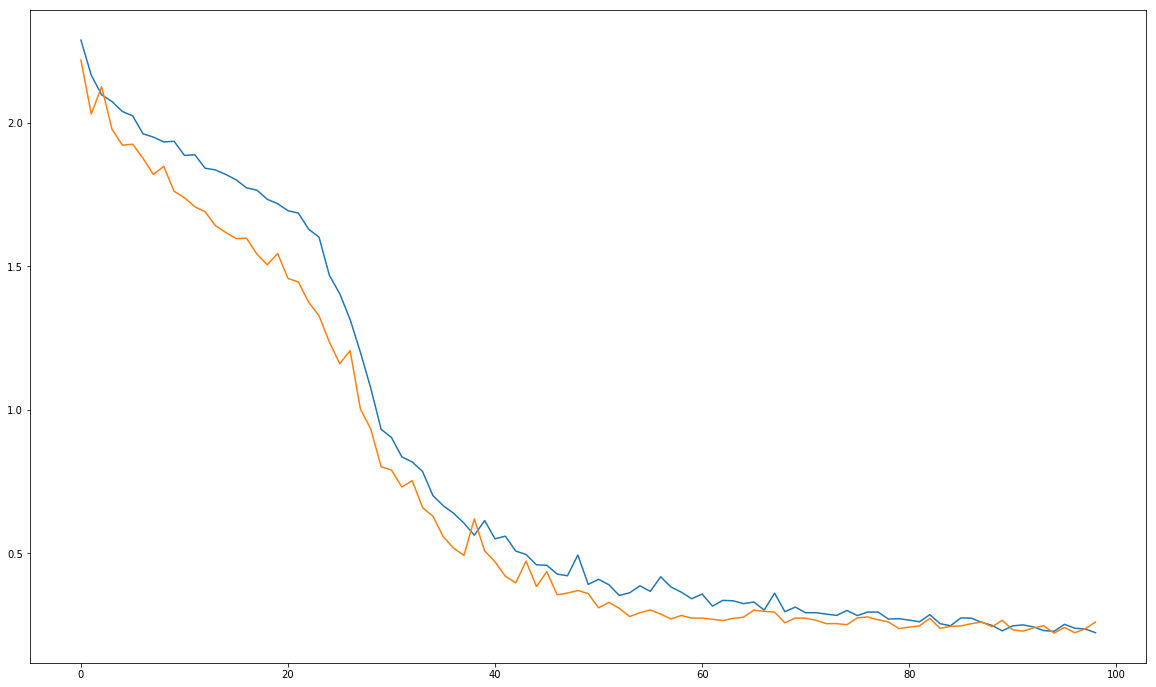

In [14]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all[1:])
plt.plot(test_losses_all[1:])
plt.show()

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(),'decoder.pt')

In [1]:
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch
from mockentries import generate_entries

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ep = EntriesProcessor(10,10)
entries = generate_entries(100000, 5)
ep.process(entries)
voc_size = ep.symbols_counter
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=10).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=10, max_output_length=10,
                  teacher_forcing_ratio=0.5, learning_rate = 0.05 )

In [2]:
train_losses_all, test_losses_all = [],[]

In [3]:
train_losses, test_losses = trainer.train(5,batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1


	Train Loss: 2.231622 	 Time: 0s

	Train Loss: 2.152674 	 Time: 0s

	Train Loss: 2.105579 	 Time: 0s

	Train Loss: 2.075169 	 Time: 1s

	Train Loss: 2.049598 	 Time: 1s

	Train Loss: 2.028689 	 Time: 1s

	Train Loss: 2.010954 	 Time: 1s

	Train Loss: 1.999999 	 Time: 2s

	Train Loss: 1.983132 	 Time: 2s

	Train Loss: 1.965954 	 Time: 2s

	Train Loss: 1.964255 	 Time: 2s

	Train Loss: 1.947843 	 Time: 2s

	Train Loss: 1.940171 	 Time: 3s

	Train Loss: 1.935915 	 Time: 3s

	Train Loss: 1.919296 	 Time: 3s

	Train Loss: 1.909701 	 Time: 3s

	Train Loss: 1.898320 	 Time: 3s

	Train Loss: 1.888137 	 Time: 4s

	Train Loss: 1.874438 	 Time: 4s

	Train Loss: 1.857618 	 Time: 4s

	Train Loss: 1.843354 	 Time: 4s

	Train Loss: 1.831355 	 Time: 5s

	Train Loss: 1.814626 	 Time: 5s

	Train Loss: 1.800121 	 Time: 5s

	Train Loss: 1.791619 	 Time: 5s

	Train Loss: 1.770154 	 Time: 5s

	Train Loss: 1.752218 	 Time: 6s

	Train Loss: 1.736176 	 Time: 6s

	Train Loss: 1.721862 	 Time: 6s

	Train Loss: 1.703073 	 Time: 6s

	Train Loss: 1.703338 	 Time: 7s

	Train Loss: 1.690031 	 Time: 7s

	Train Loss: 1.676916 	 Time: 7s

	Train Loss: 1.661093 	 Time: 7s

	Train Loss: 1.650246 	 Time: 8s

	Train Loss: 1.636700 	 Time: 8s

	Train Loss: 1.628522 	 Time: 8s

	Train Loss: 1.615187 	 Time: 8s

	Train Loss: 1.610398 	 Time: 9s

	Train Loss: 1.602361 	 Time: 9s

	Train Loss: 1.592318 	 Time: 9s

	Train Loss: 1.588038 	 Time: 9s

	Train Loss: 1.578290 	 Time: 9s

	Train Loss: 1.567387 	 Time: 10s

	Train Loss: 1.556659 	 Time: 10s

	Train Loss: 1.546053 	 Time: 10s

	Train Loss: 1.535885 	 Time: 10s

	Train Loss: 1.525970 	 Time: 10s

	Train Loss: 1.516179 	 Time: 11s

	Train Loss: 1.506739 	 Time: 11s

	Train Loss: 1.498260 	 Time: 11s

	Train Loss: 1.498564 	 Time: 11s

	Train Loss: 1.500159 	 Time: 12s

	Train Loss: 1.492295 	 Time: 12s

	Train Loss: 1.484527 	 Time: 12s

	Train Loss: 1.476713 	 Time: 12s

	Train Loss: 1.469125 	 Time: 12s

	Train Loss: 1.461607 	 Time: 13s

	Train Loss: 1.454253 	 Time: 13s

	Train Loss: 1.447188 	 Time: 13s

	Train Loss: 1.441945 	 Time: 13s

	Train Loss: 1.439577 	 Time: 14s

	Train Loss: 1.432918 	 Time: 14s

	Train Loss: 1.426437 	 Time: 14s

	Train Loss: 1.419960 	 Time: 14s

	Train Loss: 1.413364 	 Time: 14s

	Train Loss: 1.407161 	 Time: 15s

	Train Loss: 1.400959 	 Time: 15s

	Train Loss: 1.394709 	 Time: 15s

	Train Loss: 1.388655 	 Time: 15s

	Train Loss: 1.382433 	 Time: 16s

	Train Loss: 1.376284 	 Time: 16s

	Train Loss: 1.370724 	 Time: 16s

	Train Loss: 1.390192 	 Time: 16s

	Train Loss: 1.389304 	 Time: 16s

	Train Loss: 1.384658 	 Time: 17s

	Train Loss: 1.379831 	 Time: 17s

	Train Loss: 1.374763 	 Time: 17s

	Train Loss: 1.369867 	 Time: 17s

	Train Loss: 1.364854 	 Time: 18s

	Train Loss: 1.359599 	 Time: 18s

	Train Loss: 1.354324 	 Time: 18s

	Train Loss: 1.349105 	 Time: 18s

	Train Loss: 1.343863 	 Time: 18s

	Train Loss: 1.338511 	 Time: 19s

	Train Loss: 1.333145 	 Time: 19s

	Train Loss: 1.327806 	 Time: 19s

	Train Loss: 1.322366 	 Time: 19s

	Train Loss: 1.316930 	 Time: 19s

	Train Loss: 1.311450 	 Time: 20s

	Train Loss: 1.305942 	 Time: 20s

	Train Loss: 1.300208 	 Time: 20s

	Train Loss: 1.294575 	 Time: 20s

	Train Loss: 1.288881 	 Time: 21s

	Train Loss: 1.282954 	 Time: 21s

	Train Loss: 1.276975 	 Time: 21s

	Train Loss: 1.270809 	 Time: 21s

	Train Loss: 1.264447 	 Time: 21s

	Train Loss: 1.258318 	 Time: 22s

	Train Loss: 1.252153 	 Time: 22s

	Train Loss: 1.245705 	 Time: 22s

	Train Loss: 1.239303 	 Time: 22s

	Train Loss: 1.232589 	 Time: 22s

	Train Loss: 1.230387 	 Time: 23s

	Train Loss: 1.228384 	 Time: 23s

	Train Loss: 1.221912 	 Time: 23s

	Train Loss: 1.215254 	 Time: 23s

	Train Loss: 1.209049 	 Time: 24s

	Train Loss: 1.202550 	 Time: 24s

	Train Loss: 1.195243 	 Time: 24s

	Train Loss: 1.188281 	 Time: 24s

	Train Loss: 1.180591 	 Time: 24s

	Train Loss: 1.172810 	 Time: 25s

	Train Loss: 1.164830 	 Time: 25s

	Train Loss: 1.156473 	 Time: 25s

	Train Loss: 1.148034 	 Time: 25s

	Train Loss: 1.139558 	 Time: 25s

	Train Loss: 1.136731 	 Time: 26s


	Test Loss: 0.122906 	 Time: 0s
	 Input: egddb 	 Result: egddba 	 From train: 1
	 Input: aefda 	 Result: aefdaa 	 From train: 1
	 Input: cbgeg 	 Result: cbgega 	 From train: 1
	 Input: ddfeb 	 Result: ddfeba 	 From train: 1
	 Input: ccffa 	 Result: ccffaa 	 From train: 1
Epoch 2
	Train Loss: 0.122972 	 Time: 0s

	Train Loss: 0.113089 	 Time: 0s

	Train Loss: 0.104936 	 Time: 0s

	Train Loss: 0.097324 	 Time: 0s

	Train Loss: 0.090455 	 Time: 0s

	Train Loss: 0.084697 	 Time: 1s

	Train Loss: 0.079603 	 Time: 1s

	Train Loss: 0.075086 	 Time: 1s

	Train Loss: 0.071051 	 Time: 1s

	Train Loss: 0.067387 	 Time: 2s

	Train Loss: 0.064136 	 Time: 2s

	Train Loss: 0.061151 	 Time: 2s

	Train Loss: 0.058482 	 Time: 2s

	Train Loss: 0.056030 	 Time: 2s

	Train Loss: 0.053780 	 Time: 3s

	Train Loss: 0.051714 	 Time: 3s

	Train Loss: 0.049811 	 Time: 3s

	Train Loss: 0.048070 	 Time: 3s

	Train Loss: 0.046475 	 Time: 3s

	Train Loss: 0.044974 	 Time: 4s

	Train Loss: 0.043561 	 Time: 4s

	Train Loss: 0.042259 	 Time: 4s

	Train Loss: 0.041032 	 Time: 4s

	Train Loss: 0.039898 	 Time: 5s

	Train Loss: 0.038804 	 Time: 5s

	Train Loss: 0.037775 	 Time: 5s

	Train Loss: 0.036808 	 Time: 5s

	Train Loss: 0.035888 	 Time: 5s

	Train Loss: 0.035015 	 Time: 6s

	Train Loss: 0.034183 	 Time: 6s

	Train Loss: 0.033394 	 Time: 6s

	Train Loss: 0.032649 	 Time: 6s

	Train Loss: 0.031934 	 Time: 7s

	Train Loss: 0.031255 	 Time: 7s

	Train Loss: 0.030609 	 Time: 7s

	Train Loss: 0.029987 	 Time: 7s

	Train Loss: 0.029390 	 Time: 7s

	Train Loss: 0.028822 	 Time: 8s

	Train Loss: 0.028283 	 Time: 8s

	Train Loss: 0.027760 	 Time: 8s

	Train Loss: 0.027255 	 Time: 8s

	Train Loss: 0.026773 	 Time: 9s

	Train Loss: 0.026311 	 Time: 9s

	Train Loss: 0.025864 	 Time: 9s

	Train Loss: 0.025434 	 Time: 9s

	Train Loss: 0.025018 	 Time: 9s

	Train Loss: 0.024614 	 Time: 10s

	Train Loss: 0.024224 	 Time: 10s

	Train Loss: 0.023848 	 Time: 10s

	Train Loss: 0.023484 	 Time: 10s

	Train Loss: 0.023132 	 Time: 10s

	Train Loss: 0.022794 	 Time: 11s

	Train Loss: 0.022464 	 Time: 11s

	Train Loss: 0.022147 	 Time: 11s

	Train Loss: 0.021836 	 Time: 11s

	Train Loss: 0.021536 	 Time: 12s

	Train Loss: 0.021245 	 Time: 12s

	Train Loss: 0.020959 	 Time: 12s

	Train Loss: 0.020684 	 Time: 12s

	Train Loss: 0.020416 	 Time: 12s

	Train Loss: 0.020158 	 Time: 13s

	Train Loss: 0.019905 	 Time: 13s

	Train Loss: 0.019658 	 Time: 13s

	Train Loss: 0.019418 	 Time: 13s

	Train Loss: 0.019185 	 Time: 14s

	Train Loss: 0.018958 	 Time: 14s

	Train Loss: 0.018735 	 Time: 14s

	Train Loss: 0.018518 	 Time: 14s

	Train Loss: 0.018307 	 Time: 14s

	Train Loss: 0.018100 	 Time: 15s

	Train Loss: 0.017899 	 Time: 15s

	Train Loss: 0.017703 	 Time: 15s

	Train Loss: 0.017512 	 Time: 15s

	Train Loss: 0.017325 	 Time: 15s

	Train Loss: 0.017141 	 Time: 16s

	Train Loss: 0.016963 	 Time: 16s

	Train Loss: 0.016788 	 Time: 16s

	Train Loss: 0.016618 	 Time: 16s

	Train Loss: 0.016450 	 Time: 17s

	Train Loss: 0.016287 	 Time: 17s

	Train Loss: 0.016126 	 Time: 17s

	Train Loss: 0.015969 	 Time: 17s

	Train Loss: 0.015815 	 Time: 17s

	Train Loss: 0.015664 	 Time: 18s

	Train Loss: 0.015516 	 Time: 18s

	Train Loss: 0.015372 	 Time: 18s

	Train Loss: 0.015231 	 Time: 18s

	Train Loss: 0.015092 	 Time: 18s

	Train Loss: 0.014955 	 Time: 19s

	Train Loss: 0.014822 	 Time: 19s

	Train Loss: 0.014690 	 Time: 19s

	Train Loss: 0.014562 	 Time: 19s

	Train Loss: 0.014436 	 Time: 20s

	Train Loss: 0.014312 	 Time: 20s

	Train Loss: 0.014190 	 Time: 20s

	Train Loss: 0.014071 	 Time: 20s

	Train Loss: 0.013954 	 Time: 20s

	Train Loss: 0.013840 	 Time: 21s

	Train Loss: 0.013727 	 Time: 21s

	Train Loss: 0.013616 	 Time: 21s

	Train Loss: 0.013506 	 Time: 21s

	Train Loss: 0.013399 	 Time: 22s

	Train Loss: 0.013293 	 Time: 22s

	Train Loss: 0.013190 	 Time: 22s

	Train Loss: 0.013088 	 Time: 22s

	Train Loss: 0.012988 	 Time: 22s

	Train Loss: 0.012890 	 Time: 23s

	Train Loss: 0.012792 	 Time: 23s

	Train Loss: 0.012697 	 Time: 23s

	Train Loss: 0.012603 	 Time: 23s

	Train Loss: 0.012511 	 Time: 23s

	Train Loss: 0.012419 	 Time: 24s

	Train Loss: 0.012330 	 Time: 24s

	Train Loss: 0.012242 	 Time: 24s

	Train Loss: 0.012155 	 Time: 24s

	Train Loss: 0.012069 	 Time: 25s

	Train Loss: 0.011985 	 Time: 25s

	Train Loss: 0.011902 	 Time: 25s


	Test Loss: 0.002207 	 Time: 0s
	 Input: cbdbe 	 Result: cbdbea 	 From train: 1
	 Input: eggdf 	 Result: eggdfa 	 From train: 0
	 Input: bgadc 	 Result: bgadca 	 From train: 1
	 Input: gbgbe 	 Result: gbgbea 	 From train: 1
	 Input: ebgdb 	 Result: ebgdba 	 From train: 1
Epoch 3
	Train Loss: 0.002164 	 Time: 0s

	Train Loss: 0.002216 	 Time: 0s

	Train Loss: 0.002217 	 Time: 0s

	Train Loss: 0.002186 	 Time: 0s

	Train Loss: 0.002174 	 Time: 0s

	Train Loss: 0.002166 	 Time: 1s

	Train Loss: 0.002154 	 Time: 1s

	Train Loss: 0.002143 	 Time: 1s

	Train Loss: 0.002133 	 Time: 1s

	Train Loss: 0.002121 	 Time: 2s

	Train Loss: 0.002112 	 Time: 2s

	Train Loss: 0.002103 	 Time: 2s

	Train Loss: 0.002094 	 Time: 2s

	Train Loss: 0.002083 	 Time: 2s

	Train Loss: 0.002075 	 Time: 3s

	Train Loss: 0.002068 	 Time: 3s

	Train Loss: 0.002059 	 Time: 3s

	Train Loss: 0.002048 	 Time: 3s

	Train Loss: 0.002041 	 Time: 3s

	Train Loss: 0.002032 	 Time: 4s

	Train Loss: 0.002023 	 Time: 4s

	Train Loss: 0.002014 	 Time: 4s

	Train Loss: 0.002006 	 Time: 4s

	Train Loss: 0.001996 	 Time: 5s

	Train Loss: 0.001989 	 Time: 5s

	Train Loss: 0.001981 	 Time: 5s

	Train Loss: 0.001974 	 Time: 5s

	Train Loss: 0.001965 	 Time: 5s

	Train Loss: 0.001958 	 Time: 6s

	Train Loss: 0.001951 	 Time: 6s

	Train Loss: 0.001943 	 Time: 6s

	Train Loss: 0.001937 	 Time: 6s

	Train Loss: 0.001929 	 Time: 7s

	Train Loss: 0.001922 	 Time: 7s

	Train Loss: 0.001915 	 Time: 7s

	Train Loss: 0.001908 	 Time: 7s

	Train Loss: 0.001901 	 Time: 7s

	Train Loss: 0.001894 	 Time: 8s

	Train Loss: 0.001887 	 Time: 8s

	Train Loss: 0.001880 	 Time: 8s

	Train Loss: 0.001873 	 Time: 8s

	Train Loss: 0.001866 	 Time: 8s

	Train Loss: 0.001859 	 Time: 9s

	Train Loss: 0.001853 	 Time: 9s

	Train Loss: 0.001846 	 Time: 9s

	Train Loss: 0.001839 	 Time: 9s

	Train Loss: 0.001833 	 Time: 10s

	Train Loss: 0.001828 	 Time: 10s

	Train Loss: 0.001821 	 Time: 10s

	Train Loss: 0.001815 	 Time: 10s

	Train Loss: 0.001809 	 Time: 10s

	Train Loss: 0.001803 	 Time: 11s

	Train Loss: 0.001796 	 Time: 11s

	Train Loss: 0.001790 	 Time: 11s

	Train Loss: 0.001785 	 Time: 11s

	Train Loss: 0.001778 	 Time: 12s

	Train Loss: 0.001773 	 Time: 12s

	Train Loss: 0.001767 	 Time: 12s

	Train Loss: 0.001761 	 Time: 12s

	Train Loss: 0.001755 	 Time: 12s

	Train Loss: 0.001750 	 Time: 13s

	Train Loss: 0.001744 	 Time: 13s

	Train Loss: 0.001739 	 Time: 13s

	Train Loss: 0.001733 	 Time: 13s

	Train Loss: 0.001727 	 Time: 14s

	Train Loss: 0.001722 	 Time: 14s

	Train Loss: 0.001716 	 Time: 14s

	Train Loss: 0.001710 	 Time: 14s

	Train Loss: 0.001705 	 Time: 14s

	Train Loss: 0.001700 	 Time: 15s

	Train Loss: 0.001695 	 Time: 15s

	Train Loss: 0.001690 	 Time: 15s

	Train Loss: 0.001684 	 Time: 15s

	Train Loss: 0.001679 	 Time: 15s

	Train Loss: 0.001674 	 Time: 16s

	Train Loss: 0.001668 	 Time: 16s

	Train Loss: 0.001663 	 Time: 16s

	Train Loss: 0.001658 	 Time: 16s

	Train Loss: 0.001653 	 Time: 17s

	Train Loss: 0.001648 	 Time: 17s

	Train Loss: 0.001643 	 Time: 17s

	Train Loss: 0.001638 	 Time: 17s

	Train Loss: 0.001633 	 Time: 17s

	Train Loss: 0.001628 	 Time: 18s

	Train Loss: 0.001623 	 Time: 18s

	Train Loss: 0.001618 	 Time: 18s

	Train Loss: 0.001613 	 Time: 18s

	Train Loss: 0.001609 	 Time: 19s

	Train Loss: 0.001604 	 Time: 19s

	Train Loss: 0.001600 	 Time: 19s

	Train Loss: 0.001595 	 Time: 19s

	Train Loss: 0.001590 	 Time: 19s

	Train Loss: 0.001586 	 Time: 20s

	Train Loss: 0.001581 	 Time: 20s

	Train Loss: 0.001576 	 Time: 20s

	Train Loss: 0.001572 	 Time: 20s

	Train Loss: 0.001568 	 Time: 20s

	Train Loss: 0.001563 	 Time: 21s

	Train Loss: 0.001559 	 Time: 21s

	Train Loss: 0.001555 	 Time: 21s

	Train Loss: 0.001550 	 Time: 21s

	Train Loss: 0.001546 	 Time: 22s

	Train Loss: 0.001541 	 Time: 22s

	Train Loss: 0.001537 	 Time: 22s

	Train Loss: 0.001533 	 Time: 22s

	Train Loss: 0.001529 	 Time: 22s

	Train Loss: 0.001525 	 Time: 23s

	Train Loss: 0.001521 	 Time: 23s

	Train Loss: 0.001517 	 Time: 23s

	Train Loss: 0.001513 	 Time: 23s

	Train Loss: 0.001509 	 Time: 23s

	Train Loss: 0.001505 	 Time: 24s

	Train Loss: 0.001501 	 Time: 24s

	Train Loss: 0.001497 	 Time: 24s

	Train Loss: 0.001494 	 Time: 24s

	Train Loss: 0.001490 	 Time: 25s

	Train Loss: 0.001486 	 Time: 25s

	Train Loss: 0.001482 	 Time: 25s


	Test Loss: 0.001032 	 Time: 0s
	 Input: ddgdd 	 Result: ddgdda 	 From train: 1
	 Input: ccagg 	 Result: ccagga 	 From train: 1
	 Input: fedea 	 Result: fedeaa 	 From train: 0
	 Input: abcee 	 Result: abceea 	 From train: 1
	 Input: dgcbf 	 Result: dgcbfa 	 From train: 1
Epoch 4
	Train Loss: 0.000997 	 Time: 0s

	Train Loss: 0.001021 	 Time: 0s

	Train Loss: 0.001017 	 Time: 0s

	Train Loss: 0.001016 	 Time: 0s

	Train Loss: 0.001015 	 Time: 0s

	Train Loss: 0.001015 	 Time: 1s

	Train Loss: 0.001015 	 Time: 1s

	Train Loss: 0.001013 	 Time: 1s

	Train Loss: 0.001010 	 Time: 1s

	Train Loss: 0.001009 	 Time: 2s

	Train Loss: 0.001006 	 Time: 2s

	Train Loss: 0.001003 	 Time: 2s

	Train Loss: 0.001002 	 Time: 2s

	Train Loss: 0.000999 	 Time: 2s

	Train Loss: 0.000996 	 Time: 3s

	Train Loss: 0.000994 	 Time: 3s

	Train Loss: 0.000993 	 Time: 3s

	Train Loss: 0.000990 	 Time: 3s

	Train Loss: 0.000989 	 Time: 3s

	Train Loss: 0.000986 	 Time: 4s

	Train Loss: 0.000985 	 Time: 4s

	Train Loss: 0.000984 	 Time: 4s

	Train Loss: 0.000982 	 Time: 4s

	Train Loss: 0.000980 	 Time: 5s

	Train Loss: 0.000978 	 Time: 5s

	Train Loss: 0.000975 	 Time: 5s

	Train Loss: 0.000972 	 Time: 5s

	Train Loss: 0.000970 	 Time: 5s

	Train Loss: 0.000968 	 Time: 6s

	Train Loss: 0.000966 	 Time: 6s

	Train Loss: 0.000964 	 Time: 6s

	Train Loss: 0.000962 	 Time: 6s

	Train Loss: 0.000960 	 Time: 6s

	Train Loss: 0.000958 	 Time: 7s

	Train Loss: 0.000957 	 Time: 7s

	Train Loss: 0.000954 	 Time: 7s

	Train Loss: 0.000952 	 Time: 7s

	Train Loss: 0.000951 	 Time: 8s

	Train Loss: 0.000949 	 Time: 8s

	Train Loss: 0.000947 	 Time: 8s

	Train Loss: 0.000945 	 Time: 8s

	Train Loss: 0.000943 	 Time: 8s

	Train Loss: 0.000941 	 Time: 9s

	Train Loss: 0.000939 	 Time: 9s

	Train Loss: 0.000937 	 Time: 9s

	Train Loss: 0.000935 	 Time: 9s

	Train Loss: 0.000933 	 Time: 9s

	Train Loss: 0.000932 	 Time: 10s

	Train Loss: 0.000930 	 Time: 10s

	Train Loss: 0.000928 	 Time: 10s

	Train Loss: 0.000926 	 Time: 10s

	Train Loss: 0.000924 	 Time: 11s

	Train Loss: 0.000922 	 Time: 11s

	Train Loss: 0.000920 	 Time: 11s

	Train Loss: 0.000919 	 Time: 11s

	Train Loss: 0.000917 	 Time: 11s

	Train Loss: 0.000915 	 Time: 12s

	Train Loss: 0.000913 	 Time: 12s

	Train Loss: 0.000911 	 Time: 12s

	Train Loss: 0.000910 	 Time: 12s

	Train Loss: 0.000908 	 Time: 12s

	Train Loss: 0.000906 	 Time: 13s

	Train Loss: 0.000904 	 Time: 13s

	Train Loss: 0.000903 	 Time: 13s

	Train Loss: 0.000901 	 Time: 13s

	Train Loss: 0.000899 	 Time: 14s

	Train Loss: 0.000897 	 Time: 14s

	Train Loss: 0.000896 	 Time: 14s

	Train Loss: 0.000894 	 Time: 14s

	Train Loss: 0.000892 	 Time: 14s

	Train Loss: 0.000891 	 Time: 15s

	Train Loss: 0.000889 	 Time: 15s

	Train Loss: 0.000888 	 Time: 15s

	Train Loss: 0.000886 	 Time: 15s

	Train Loss: 0.000884 	 Time: 16s

	Train Loss: 0.000883 	 Time: 16s

	Train Loss: 0.000882 	 Time: 16s

	Train Loss: 0.000880 	 Time: 16s

	Train Loss: 0.000878 	 Time: 16s

	Train Loss: 0.000877 	 Time: 17s

	Train Loss: 0.000875 	 Time: 17s

	Train Loss: 0.000874 	 Time: 17s

	Train Loss: 0.000872 	 Time: 17s

	Train Loss: 0.000870 	 Time: 17s

	Train Loss: 0.000869 	 Time: 18s

	Train Loss: 0.000867 	 Time: 18s

	Train Loss: 0.000866 	 Time: 18s

	Train Loss: 0.000864 	 Time: 18s

	Train Loss: 0.000863 	 Time: 19s

	Train Loss: 0.000861 	 Time: 19s

	Train Loss: 0.000860 	 Time: 19s

	Train Loss: 0.000858 	 Time: 19s

	Train Loss: 0.000857 	 Time: 19s

	Train Loss: 0.000855 	 Time: 20s

	Train Loss: 0.000854 	 Time: 20s

	Train Loss: 0.000852 	 Time: 20s

	Train Loss: 0.000851 	 Time: 20s

	Train Loss: 0.000849 	 Time: 20s

	Train Loss: 0.000848 	 Time: 21s

	Train Loss: 0.000847 	 Time: 21s

	Train Loss: 0.000845 	 Time: 21s

	Train Loss: 0.000844 	 Time: 21s

	Train Loss: 0.000842 	 Time: 22s

	Train Loss: 0.000841 	 Time: 22s

	Train Loss: 0.000839 	 Time: 22s

	Train Loss: 0.000838 	 Time: 22s

	Train Loss: 0.000836 	 Time: 22s

	Train Loss: 0.000835 	 Time: 23s

	Train Loss: 0.000833 	 Time: 23s

	Train Loss: 0.000832 	 Time: 23s

	Train Loss: 0.000831 	 Time: 23s

	Train Loss: 0.000829 	 Time: 24s

	Train Loss: 0.000828 	 Time: 24s

	Train Loss: 0.000827 	 Time: 24s

	Train Loss: 0.000825 	 Time: 24s

	Train Loss: 0.000824 	 Time: 24s

	Train Loss: 0.000822 	 Time: 25s

	Train Loss: 0.000821 	 Time: 25s


	Test Loss: 0.000661 	 Time: 0s
	 Input: faafd 	 Result: faafda 	 From train: 1
	 Input: ggfgd 	 Result: ggfgda 	 From train: 1
	 Input: bbbef 	 Result: bbbefa 	 From train: 1
	 Input: bcabe 	 Result: bcabea 	 From train: 1
	 Input: deegc 	 Result: deegca 	 From train: 1
Epoch 5
	Train Loss: 0.000656 	 Time: 0s

	Train Loss: 0.000659 	 Time: 0s

	Train Loss: 0.000663 	 Time: 0s

	Train Loss: 0.000657 	 Time: 0s

	Train Loss: 0.000656 	 Time: 0s

	Train Loss: 0.000655 	 Time: 1s

	Train Loss: 0.000653 	 Time: 1s

	Train Loss: 0.000653 	 Time: 1s

	Train Loss: 0.000653 	 Time: 1s

	Train Loss: 0.000652 	 Time: 2s

	Train Loss: 0.000652 	 Time: 2s

	Train Loss: 0.000652 	 Time: 2s

	Train Loss: 0.000651 	 Time: 2s

	Train Loss: 0.000651 	 Time: 2s

	Train Loss: 0.000650 	 Time: 3s

	Train Loss: 0.000648 	 Time: 3s

	Train Loss: 0.000647 	 Time: 3s

	Train Loss: 0.000646 	 Time: 3s

	Train Loss: 0.000645 	 Time: 3s

	Train Loss: 0.000644 	 Time: 4s

	Train Loss: 0.000643 	 Time: 4s

	Train Loss: 0.000642 	 Time: 4s

	Train Loss: 0.000641 	 Time: 4s

	Train Loss: 0.000640 	 Time: 5s

	Train Loss: 0.000639 	 Time: 5s

	Train Loss: 0.000638 	 Time: 5s

	Train Loss: 0.000637 	 Time: 5s

	Train Loss: 0.000637 	 Time: 5s

	Train Loss: 0.000636 	 Time: 6s

	Train Loss: 0.000635 	 Time: 6s

	Train Loss: 0.000634 	 Time: 6s

	Train Loss: 0.000633 	 Time: 6s

	Train Loss: 0.000632 	 Time: 7s

	Train Loss: 0.000631 	 Time: 7s

	Train Loss: 0.000630 	 Time: 7s

	Train Loss: 0.000629 	 Time: 7s

	Train Loss: 0.000628 	 Time: 7s

	Train Loss: 0.000627 	 Time: 8s

	Train Loss: 0.000626 	 Time: 8s

	Train Loss: 0.000625 	 Time: 8s

	Train Loss: 0.000624 	 Time: 8s

	Train Loss: 0.000623 	 Time: 8s

	Train Loss: 0.000622 	 Time: 9s

	Train Loss: 0.000621 	 Time: 9s

	Train Loss: 0.000620 	 Time: 9s

	Train Loss: 0.000619 	 Time: 9s

	Train Loss: 0.000618 	 Time: 10s

	Train Loss: 0.000618 	 Time: 10s

	Train Loss: 0.000617 	 Time: 10s

	Train Loss: 0.000616 	 Time: 10s

	Train Loss: 0.000615 	 Time: 10s

	Train Loss: 0.000614 	 Time: 11s

	Train Loss: 0.000613 	 Time: 11s

	Train Loss: 0.000612 	 Time: 11s

	Train Loss: 0.000612 	 Time: 11s

	Train Loss: 0.000611 	 Time: 12s

	Train Loss: 0.000610 	 Time: 12s

	Train Loss: 0.000609 	 Time: 12s

	Train Loss: 0.000608 	 Time: 12s

	Train Loss: 0.000607 	 Time: 12s

	Train Loss: 0.000607 	 Time: 13s

	Train Loss: 0.000606 	 Time: 13s

	Train Loss: 0.000605 	 Time: 13s

	Train Loss: 0.000604 	 Time: 13s

	Train Loss: 0.000603 	 Time: 14s

	Train Loss: 0.000603 	 Time: 14s

	Train Loss: 0.000602 	 Time: 14s

	Train Loss: 0.000601 	 Time: 14s

	Train Loss: 0.000600 	 Time: 14s

	Train Loss: 0.000600 	 Time: 15s

	Train Loss: 0.000599 	 Time: 15s

	Train Loss: 0.000598 	 Time: 15s

	Train Loss: 0.000597 	 Time: 15s

	Train Loss: 0.000596 	 Time: 15s

	Train Loss: 0.000596 	 Time: 16s

	Train Loss: 0.000595 	 Time: 16s

	Train Loss: 0.000594 	 Time: 16s

	Train Loss: 0.000593 	 Time: 16s

	Train Loss: 0.000593 	 Time: 17s

	Train Loss: 0.000592 	 Time: 17s

	Train Loss: 0.000591 	 Time: 17s

	Train Loss: 0.000590 	 Time: 17s

	Train Loss: 0.000589 	 Time: 17s

	Train Loss: 0.000589 	 Time: 18s

	Train Loss: 0.000588 	 Time: 18s

	Train Loss: 0.000587 	 Time: 18s

	Train Loss: 0.000586 	 Time: 18s

	Train Loss: 0.000585 	 Time: 18s

	Train Loss: 0.000585 	 Time: 19s

	Train Loss: 0.000584 	 Time: 19s

	Train Loss: 0.000583 	 Time: 19s

	Train Loss: 0.000583 	 Time: 19s

	Train Loss: 0.000582 	 Time: 20s

	Train Loss: 0.000581 	 Time: 20s

	Train Loss: 0.000581 	 Time: 20s

	Train Loss: 0.000580 	 Time: 20s

	Train Loss: 0.000579 	 Time: 20s

	Train Loss: 0.000579 	 Time: 21s

	Train Loss: 0.000578 	 Time: 21s

	Train Loss: 0.000577 	 Time: 21s

	Train Loss: 0.000576 	 Time: 21s

	Train Loss: 0.000576 	 Time: 21s

	Train Loss: 0.000575 	 Time: 22s

	Train Loss: 0.000574 	 Time: 22s

	Train Loss: 0.000574 	 Time: 22s

	Train Loss: 0.000573 	 Time: 22s

	Train Loss: 0.000572 	 Time: 23s

	Train Loss: 0.000572 	 Time: 23s

	Train Loss: 0.000571 	 Time: 23s

	Train Loss: 0.000570 	 Time: 23s

	Train Loss: 0.000569 	 Time: 23s

	Train Loss: 0.000569 	 Time: 24s

	Train Loss: 0.000568 	 Time: 24s

	Train Loss: 0.000567 	 Time: 24s

	Train Loss: 0.000567 	 Time: 24s

	Train Loss: 0.000566 	 Time: 25s

	Train Loss: 0.000565 	 Time: 25s

	Train Loss: 0.000565 	 Time: 25s


	Test Loss: 0.000485 	 Time: 0s
	 Input: dddff 	 Result: dddffa 	 From train: 1
	 Input: dgagf 	 Result: dgagfa 	 From train: 1
	 Input: aedaf 	 Result: aedafa 	 From train: 1
	 Input: bcecf 	 Result: bcecfa 	 From train: 1
	 Input: fedaf 	 Result: fedafa 	 From train: 1
